# 第12組_社群媒體分析_期末專案_文詞分析

## 組別：Group 12
## 題目：PTT論壇AI相關議題的語料分析與趨勢探勘
### 使用工具：Python

M134020005 馮祐倫  
M134020051 柯昆霖

報告影片連結：https://youtu.be/NcM5DaE0uTg


## 目的
2023 年起，生成式 AI 帶來了前所未有的變革浪潮。從 ChatGPT 到 Midjourney、從人工到自動化，AI 正以前所未有的速度滲透人們的工作與生活。  
而在台灣最具代表性的網路論壇之一——PTT，鄉民們也開始熱烈討論這波浪潮帶來的機會與焦慮。

本專案計畫分析和說明以下三個核心問題：

1. PTT 社群如何看待 AI 在職場與科技工作的角色與影響？

2. 各主要實體（如：公司、技術、人物等）在討論中扮演什麼樣的網絡位置與影響力？

3. 不同主題下的情緒傾向與輿論熱點為何？


透過各種不同的分析，進一步揭示各實體在社群中的連結強度、討論中心性與潛在社群結構：

1. 情緒分析 (Sentiment Analysis)

    目的：判斷貼文中對 AI 的整體情感傾向（正向、中立、負向）。

    應用：了解網友對 AI 技術、AI 應用在工作上，以及 AI 對職場未來影響的情緒態度，並進一步探索情緒隨時間或議題的變化趨勢。

2. 主題模型分析 (Topic Modeling)

    目的：藉由 BERTopic 方法，自動挖掘貼文中的主題結構，找出幾大核心討論議題。

    應用：了解在「AI+工作」範疇內，網友最關注哪些面向（例如「AI 自動化取代工作」、「AI 招募面試應用」、「AI 技能學習建議」……），並分析每個主題的情緒分佈與實體共現情況。

3. 命名實體識別 (NER)

    目的：自動偵測並抽取貼文中的組織（ORG）、人物（PERSON）、產品（PRODUCT）、技術（TECH）等實體。

    應用：辨識出在 AI 討論中最常被提及的公司（如台積電、NVIDIA）、研究單位、意見領袖，或是關鍵技術名詞，為後續網路圖與主題建模提供實體基礎。

4. 網路圖構建 (Network Graph Analysis)

    目的：將貼文中的實體 (經由 NER) 與關鍵詞或使用者互動關係視覺化為節點與邊，構建實體共現網路或使用者互動網路。

    應用：揭示 AI 議題中各實體之間的關聯強度（例如哪些公司或技術一起被討論最多）、意見領袖的社群結構，以及不同主題或情緒社群的網絡分布。


綜合以上，能更立體地描繪出台灣論壇使用者在 AI 職場議題中的討論趨勢、關注焦點與情緒反應。


## 資料集概覽

此資料集收集自台灣的社群媒體平台 PTT。  
PTT「工作」、「職場」、「科技工作」三個版中，針對含有 “AI” 關鍵字的貼文。  
資料收集範圍從 2024 年 5 月 1 日到 2025 年 5 月 1 日，共包含 2456 筆資料。

## 資料欄位說明

資料集包含以下 10 個欄位：

1. `system_id`: 系統編號
2. `artComment`: 文章評論
3. `artDate`: 文章日期
4. `insertedDate`: 插入日期
5. `artContent`: 文章內容
6. `artCatagory`: 文章類別
7. `dataSource`: 資料來源
8. `artPoster`: 發文者
9. `artTitle`: 文章標題。
10. `artUrl`: 文章網址

### 套件插入

In [1]:
import pandas as pd
import jieba
import jieba.analyse
import re
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from tqdm import tqdm
from nltk import ngrams, FreqDist
from wordcloud import WordCloud

### 字型格式設定

In [2]:
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # macOS 的中文系統字型
plt.rcParams['axes.unicode_minus'] = False         # 正常顯示負號

## 資料集載入

In [3]:
df = pd.read_csv('Merged.csv')
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt
1,2,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,[新聞]年後轉職最熱門公司出爐前三名台積電、,2024-05-01 17:24:04,qazxc1156892,Tech_Job,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""abc21086999""...",223.137.1.131,2024-05-02 02:19:38,ptt
2,3,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,[新聞]訓練台版AI語言模型，許永真：盼讓百工,2024-05-01 17:48:08,pl132,Tech_Job,訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ling621"", ""c...",180.177.2.112,2024-05-02 02:19:38,ptt
3,4,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,[新聞]首屆台法科研會議吳政忠：六大領域可望,2024-05-01 21:41:58,createlight,Tech_Job,https://www.epochtimes.com/b5/24/4/30/n1423755...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""unima"", ""cmt...",114.39.34.219,2024-05-02 02:19:38,ptt
4,5,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,[心得]電子業PM面試紀錄（長文）,2024-05-01 21:43:46,tin8420,Tech_Job,https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KMTlikesshit...",118.231.160.114,2024-05-02 02:19:38,ptt


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   system_id     2457 non-null   object
 1   artUrl        2457 non-null   object
 2   artTitle      2457 non-null   object
 3   artDate       2457 non-null   object
 4   artPoster     2457 non-null   object
 5   artCatagory   2457 non-null   object
 6   artContent    2457 non-null   object
 7   artComment    2457 non-null   object
 8   e_ip          2440 non-null   object
 9   insertedDate  2457 non-null   object
 10  dataSource    2457 non-null   object
dtypes: object(11)
memory usage: 211.3+ KB


In [5]:
# Path to the custom font
font_path = 'font/TaipeiSansTCBeta-Regular.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Taipei Sans TC Beta


In [6]:
# window
# plt.rcParams['font.family'] = 'Noto Sans TC'
# plt.rcParams['axes.unicode_minus'] = False

# mac
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # macOS 的中文系統字型
plt.rcParams['axes.unicode_minus'] = False         

In [7]:
# 複製原始資料集
clear_df = df.copy()

# 去除本次不會用到的欄位
drop_cols = ['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

# 去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

# 新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

# 移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

# 只留下中文字
clear_df['sentence'] = clear_df['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

clear_df.head(10)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...
1,2,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,[新聞]年後轉職最熱門公司出爐前三名台積電、,2024-05-01 17:24:04,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...,新聞標題年後轉職最熱門公司出爐前三名台積電華碩台達電經濟日報記者葉卉軒台北即時報導年後轉職潮...
2,3,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,[新聞]訓練台版AI語言模型，許永真：盼讓百工,2024-05-01 17:48:08,訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...,訓練台版語言模型許永真盼讓百工百業商用國科會去年月啟動計畫研發台版大型繁中語言模型台大資工系...
3,4,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,[新聞]首屆台法科研會議吳政忠：六大領域可望,2024-05-01 21:41:58,https://www.epochtimes.com/b5/24/4/30/n1423755...,首屆台法科研會議吳政忠六大領域可望締造雙贏圖左起國科會副主委陳儀莊國科會主委吳政忠法國在台協...
4,5,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,[心得]電子業PM面試紀錄（長文）,2024-05-01 21:43:46,https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...,網誌版商科學士傳產生管年多益金色前份半路出家去寫程式資訊業不太適應就回到製造業而在科技業寒冬...
5,6,https://www.ptt.cc/bbs/Tech_Job/M.1714571075.A...,[新聞]美晶片陷缺工危機須靠外籍人才填補,2024-05-01 21:44:23,https://ec.ltn.com.tw/article/breakingnews/465...,美晶片陷缺工危機須靠外籍人才填補美國晶片廠面臨缺工問題須要引進大量外籍人才填補缺口路透吳孟峰...
6,7,https://www.ptt.cc/bbs/Tech_Job/M.1714608383.A...,[新聞]那「一通電話」白打了？台積電恐放棄在,2024-05-02 08:06:20,那「一通電話」白打了？台積電恐放棄在銅鑼建先進封裝廠\n\n〔記者洪友芳／新竹報導〕\n晶圓...,那一通電話白打了台積電恐放棄在銅鑼建先進封裝廠記者洪友芳新竹報導晶圓代工廠力積電今日上午將舉...
7,8,https://www.ptt.cc/bbs/Tech_Job/M.1714621623.A...,科企裁員潮｜Google裁減至少200名「核心」團隊,2024-05-02 11:47:00,https://inews.hket.com/article/3753047\n科企裁員潮｜...,科企裁員潮裁減至少名核心團隊員工部分職位轉移到印度和墨西哥母企美據報上星期公布季度業績前已裁...
8,9,https://www.ptt.cc/bbs/Tech_Job/M.1714625026.A...,[新聞]今年要繳稅335萬…眾人秒跪！10年工程師,2024-05-02 12:43:42,今年要繳稅335萬…眾人秒跪！10年工程師：感謝「海產店」照顧\nhttps://finan...,今年要繳稅萬眾人秒跪年工程師感謝海產店照顧新聞雲財經雲瑞昱圖翻攝自瑞昱官網記者鄺郁庭綜合報導...
9,10,https://www.ptt.cc/bbs/Tech_Job/M.1714629835.A...,[新聞]外媒：台積電作為世界領導者股價實在太,2024-05-02 14:03:51,外媒：台積電作為世界領導者 股價實在太便宜\n\n高佳菁／核稿編輯\n\n〔財經頻道／綜合報...,外媒台積電作為世界領導者股價實在太便宜高佳菁核稿編輯財經頻道綜合報導電訊報的專欄指出台積電具...


## 1.0 資料清理

### 1.1 斷詞設定

In [8]:
# 初始化斷詞引擎
jieba.set_dictionary('dict/dict.txt') 

# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
# jieba.load_userdict('dict/user_dict.txt')

# 參數形式手動將字詞加入斷詞字典
words = ["行動或市內電話"]
for w in words:
    jieba.add_word(w, freq=None, tag=None)

Building prefix dict from /Users/kunlin/Documents/NSYSU_中山大學/113-2 課程/MIS581_社群媒體分析/期末專案/dict/dict.txt ...
Loading model from cache /var/folders/jl/rs16gbqd5bz6g1r6y4xjtp480000gn/T/jieba.u4a927e526febc3de6ec7274c5bfb7a24.cache
Loading model cost 0.344 seconds.
Prefix dict has been built successfully.


### 1.2 停用字

In [9]:
# 使用預設的停用字字典
with open('dict/stop_words.txt', 'r', encoding="utf8") as f:
    stopwords = f.read().splitlines()  #移除換行符號\n

# 手動設定加入停用字
user_stop = [
    "文章","刪除","通知","配合","性別","張貼","發文","兩行","確實","中心","經濟日報","很凍",
    "的", "來", "對於", "愈來愈", "就是", "什麼","目前","事項","活動","交辦","二日","週休","人員",
    "人員", "系統", "行政", "小時", "超過", "具備","遵守","現行","自負","確知","文責","服務法","服務",
    "空白", "00", "同義文字", "email", "站各級", "延長工時","應注意", "條文", "註明", "保",
    "電子郵件", "市內電話", "條款", "限制", "項", "留", "單位", "名稱", "法律","條例", "使用者",
    "詳盡", "資訊", "規範", "本條", "網站",  "特殊", "條件", "時間", "內容", "其餘項目", "但不得", "本",
    "為每小時", "單位者", "為每小時", "依", "行", "相關", "第一項", "其他","現行法律", "其餘項留", "情況", "具體",
    "protected", "未註明",  "可以", "認為", "包括", "注意事項", 'our', '請務必', '務必詳述',
    "目前", "包含", "進行", "指出", "the", "and", '表示', '我們', '可能', '原文標題',
    "同時", "問題", "影響", "因此", "以及", "發展" '原文連結','原文內容', 'in', 'on', 'for', 'that',
    '心得評論', '工作', '使用', '現在', '已經', '因為', '自己', '透過', '他們', '提供', '開始', '不過', '需要',
    '記者署名', '去年', '成為', '針對', '如果', '甚至', '推出', '出現', '部分', '領域', '開發', '政府', '所以', '方式',
    '希望', '還是', '能力', '由於', '除了', '請具體', '方面', '獲得', '主要', '過去', '提升', '該公司', '資料', '此外',
    '報導', '生產', '能夠', '例如', '詳述狀況', '強調', '解決方案', '是否', '非常', '以上', '研究', '無法', '成功',
    '結果', '完成', '不同', '這樣', '如何', '機會', '安全', '數據', '處理', '研發', '宣布', '模型', '記者', '重要',
    '國家', '預估', '直接', '設備', '業者', '網路', '擁有', '之一', '另外', '利用', '必須', '支持', '成本', '應用',
    '一個', '人工智慧','人工', '智慧', 'AI', '公司', '市場', '億美元', '美元', 'rs', '這些', '表現', 'of', '持續', '雖然', '億元',
    '根據', '團隊', '隨著', '客戶', '其中', 'to', '這個', '未來', '平台', '產業', '產品', '今年', '今天', '預計', '預期']

for i in user_stop:
    stopwords.append(i)

pd.DataFrame(stopwords, columns=['停用詞'])

,停用詞
0,","
1,?
2,、
3,。
4,“
...,...
1437,產品
1438,今年
1439,今天
1440,預計


### 1.3 斷詞

In [10]:
# 設定斷詞 function
def get_token(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]

    return seg_list

In [11]:
tqdm.pandas()

data = clear_df.copy()

# 斷詞後會是一個 list，例如 ['我', '喜歡', '工作']
data['word'] = data['sentence'].progress_apply(get_token)

# 使用 explode 把 list 展開為一列一詞
data = data.explode('word')


data.head(10)

100%|██████████| 2457/2457 [00:06<00:00, 383.09it/s]


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,明顯
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,之前
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,面試
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,遇過
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,明擺
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,著開
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,太高
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,陣子
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,業界
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,好像


In [12]:
# 查看目前有哪些詞
freq_df = pd.DataFrame(data['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
# freq_df.head(80)
pd.set_option('display.max_rows', 100)  # 或更多，視需要調整
display(freq_df.head(30))


,word,count
0,台灣,2426
1,美國,2004
2,台積電,1969
3,晶片,1952
4,勞健保,1761
5,技術,1734
6,計畫,1661
7,經驗,1499
8,員工,1431
9,輝達,1421


## 2.0 TF-IDF

In [13]:
def getToken2(text):
    if not isinstance(text, str):
        return []

    eng_list = ['tsmc', 'nvidia', 'intel', 'openai', 'chatgpt', 'google', 'aws', 'ai', 'gpu', 'rm' , 'hr' , 'llm' , 'agentic','micron' ]
    tokens = []

    for w in jieba.lcut(text):
        w = w.strip()

        if len(w) <= 1:
            continue
        if w in stopwords:
            continue
        if re.search(r'[A-Za-z]+', w):  # 是英文
            if w.lower() in eng_list:
                tokens.append(w.lower())  # 統一小寫處理
            continue
        tokens.append(w)  # 中文詞保留

    return tokens


In [14]:
# 建立副本避免污染原資料
n_df = clear_df.copy()

n_df = n_df[["system_id", "sentence"]]

n_df['word'] = n_df['sentence'].apply(getToken2).apply(lambda x: ' '.join(x))

n_df.head()


,system_id,sentence,word
0,1,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,明顯 之前 面試 遇過 明擺 著開 太高 陣子 業界 好像 畢業 整個人 充滿 求職 焦慮 ...
1,2,新聞標題年後轉職最熱門公司出爐前三名台積電華碩台達電經濟日報記者葉卉軒台北即時報導年後轉職潮...,新聞 標題 轉職 熱門 出爐 前三名 台積電 華碩 台達電 葉卉軒 台北 即時 轉職 延長 ...
2,3,訓練台版語言模型許永真盼讓百工百業商用國科會去年月啟動計畫研發台版大型繁中語言模型台大資工系...,訓練 台版 語言 許永真 百工 百業 商用 國科會 啟動 計畫 台版 大型 繁中 語言 台大...
3,4,首屆台法科研會議吳政忠六大領域可望締造雙贏圖左起國科會副主委陳儀莊國科會主委吳政忠法國在台協...,首屆 台法 科研 會議 吳政忠 六大 可望 締造 雙贏 左起 國科會 副主委 儀莊 國科會 ...
4,5,網誌版商科學士傳產生管年多益金色前份半路出家去寫程式資訊業不太適應就回到製造業而在科技業寒冬...,網誌 商科 學士 產生 管年 多益 金色 前份 半路出家 程式 資訊業 適應 回到 製造業 ...


### 2.1 計算 TF-IDF

In [15]:
# 蠻稀疏的矩陣
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(n_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df.head()

,一一,一一年,一丁點,一三五,一三四五,一三是,一下,一下子,一不限,一中,...,龍華,龍門,龍頭,龍頭廠,龐大,龔明鑫,龔芸,龜山,龜山區,龜山島
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,8,0,0,0,...,3,0,0,0,0,0,0,0,0,0


In [16]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df.head()

,一一,一一年,一丁點,一三五,一三四五,一三是,一下,一下子,一不限,一中,...,龍華,龍門,龍頭,龍頭廠,龐大,龔明鑫,龔芸,龜山,龜山區,龜山島
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.034535,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.069526,0.0,0.0,0.0,...,0.044802,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2 檢視TF-IDF結果

In [17]:
# 法一: 看平均值
tfidf_avg = TFIDF_df.mean().to_frame().reset_index() ## !!
tfidf_avg.columns = ["word", "avg"]

tfidf_avg.sort_values('avg', ascending = False).head(10)

,word,avg
6321,勞健保,0.024695
7649,台灣,0.022314
27941,計畫,0.022031
7670,台積電,0.021325
17478,晶片,0.020206
25386,美國,0.019012
24935,經驗,0.018472
29832,輝達,0.017806
6334,勞基法,0.017098
6242,助理,0.017024


In [18]:
# 法二: 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一一年,一丁點,一三五,一三四五,一三是,一下,一下子,一不限,...,龍華,龍門,龍頭,龍頭廠,龐大,龔明鑫,龔芸,龜山,龜山區,龜山島
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.034535,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.069526,0.0,0.0,...,0.044802,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,2453,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2453,2454,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2454,2455,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2455,2456,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
84756667,2453,龜山島,0.0
84756668,2454,龜山島,0.0
84756669,2455,龜山島,0.0
84756670,2456,龜山島,0.0


In [20]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

/var/folders/jl/rs16gbqd5bz6g1r6y4xjtp480000gn/T/ipykernel_21800/3283726584.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
2285,台積電,157
2274,台灣,141
5201,晶片,141
8213,計畫,139
7461,美國,127
8707,輝達,124
362,中國,94
1838,助理,93
2478,員工,78
7816,英特爾,74


從我們以 TF-IDF 計算出的高權重詞彙來看，出現頻率最高的關鍵字包括「台積電」、「台灣」、「晶片」、「輝達」、「美國」與「英特爾」等，
可以很明顯地看出整體語料還是高度聚焦在以台積電為核心的台灣半導體產業鏈，也就是俗稱的「護國神山」。

## 3.0 n-gram幫助建立斷詞字典

In [21]:
eng_list = ['tsmc', 'nvidia', 'intel', 'openai', 'chatgpt', 'google', 'aws', 'ai', 'gpu', 'rm' , 'hr' , 'llm' , 'agentic','micron' ]

def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    tokens = []
    for w in seg_list:
        if len(w) <= 1:
            continue
        if w in stopwords:
            continue
        # 保留特定英文字
        if re.search(r'[A-Za-z]+', w):  
            if w.lower() in eng_list:
                tokens.append(w)
            else:
                continue
        else:
            # 其餘不處理
            tokens.append(w) 

    # ngram斷詞
    tokens = ngrams(tokens, n)
    tokens = [" ".join(w) for w in list(tokens)]
    
    return tokens

### 3.1 Bigram

In [22]:
ai_bigram = data.copy()

ai_bigram["word"] = ai_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
ai_bigram = ai_bigram.explode('word')

ai_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,明顯 之前
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,之前 面試
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,面試 遇過


In [23]:
# 統計最常出現的bigram組合
# 計算每個組合出現的次數

ai_bigram_count = ai_bigram['word'].value_counts().reset_index()
ai_bigram_count.sort_values('count', ascending=False).head(40)

,word,count
0,就業 平等,140178
2,違反 就業,138533
1,禁止 違反,138533
3,遵循 勞健保,138280
4,同意 遵循,138280
5,勞基法 同意,138205
7,工作法 勞基法,131033
6,平等 工作法,131033
8,勞健保 資方,118613
9,身心 障礙,85465


### 3.2 Trigram

In [24]:
ai_trigram = data.copy()

ai_trigram["word"] = ai_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
ai_trigram = ai_trigram.explode('word')

ai_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,明顯 之前 面試
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,之前 面試 遇過
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,面試 遇過 明擺


In [25]:
# 統計最常出現的trigram組合
# 計算每個組合出現的次數
ai_trigram_count = ai_trigram['word'].value_counts().reset_index()

ai_trigram_count.sort_values('count', ascending=False).head(40)

,word,count
0,違反 就業 平等,138533
1,禁止 違反 就業,138533
2,同意 遵循 勞健保,138280
3,勞基法 同意 遵循,138205
4,就業 平等 工作法,131033
5,平等 工作法 勞基法,131033
6,工作法 勞基法 同意,130780
7,遵循 勞健保 資方,118613
11,出生地 性傾向 年齡,77045
12,性傾向 年齡 婚姻,77045


### 文字雲

In [26]:
word_cloud = data.copy()


# 斷詞、去除停用字並將word欄位展開
# 助教的
word_cloud['word'] = word_cloud.sentence.apply(getToken2).explode('word')

# 修正的
word_cloud['word'] = word_cloud.sentence.apply(getToken2)
word_cloud = word_cloud.explode('word')

word_cloud.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,明顯
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,之前
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,面試


/var/folders/jl/rs16gbqd5bz6g1r6y4xjtp480000gn/T/ipykernel_21800/4217996110.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df= pd.DataFrame(pd.value_counts(word_cloud['word'])).sort_values(by = ['count'], ascending = False).reset_index()


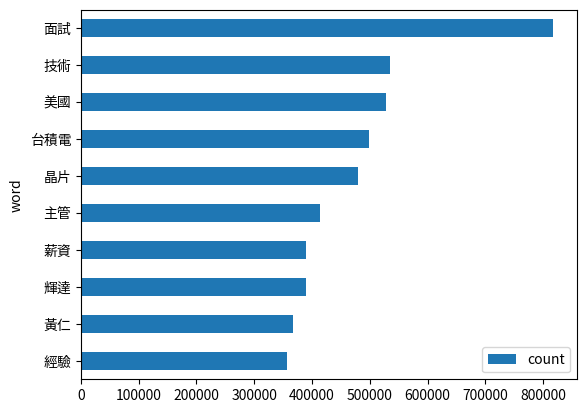

In [ ]:
freq_df= pd.DataFrame(pd.value_counts(word_cloud['word'])).sort_values(by = ['count'], ascending = False).reset_index()

filtered_df = freq_df[~freq_df['word'].isin(exclude_words)]

filtered_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

/var/folders/jl/rs16gbqd5bz6g1r6y4xjtp480000gn/T/ipykernel_21800/1348879023.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df= pd.DataFrame(pd.value_counts(word_cloud['word'])).sort_values(by = ['count'], ascending = False).reset_index()


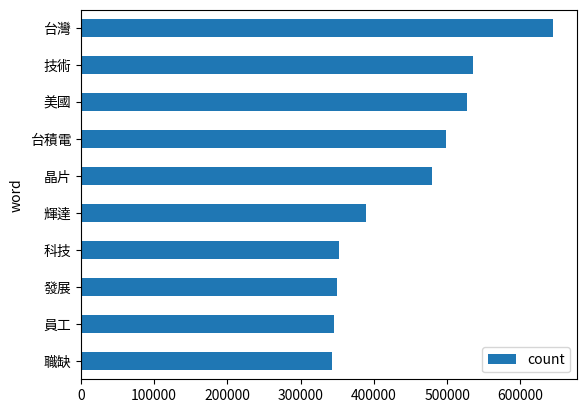

In [31]:
freq_df= pd.DataFrame(pd.value_counts(word_cloud['word'])).sort_values(by = ['count'], ascending = False).reset_index()

# 移除 搜尋的關鍵字
exclude_words = ['黃仁', '薪資', '主管', '面試', '經驗',]
filtered_df = freq_df[~freq_df['word'].isin(exclude_words)]

filtered_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

In [34]:
FontPath = 'font/SourceHanSansTW-Regular.otf'

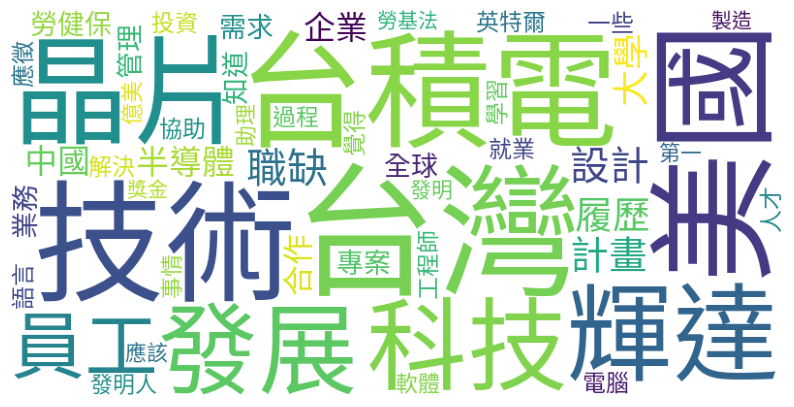

In [35]:
freq_dict = filtered_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

In [36]:
data_cor = data.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken2).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,明顯 之前 面試 遇過 明擺 著開 太高 陣子 業界 好像 畢業 整個人 充滿 求職 焦慮 ...
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,明顯 之前 面試 遇過 明擺 著開 太高 陣子 業界 好像 畢業 整個人 充滿 求職 焦慮 ...
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,明顯 之前 面試 遇過 明擺 著開 太高 陣子 業界 好像 畢業 整個人 充滿 求職 焦慮 ...


In [37]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
# min_df = 5 該字詞必須出現在5篇文章以上
vectorizer = CountVectorizer(min_df = 5, max_features = 200)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一下,一些,一定,一年,一直,三星,上班,世界,中國,主管,...,關係,關鍵,障礙,電子,電腦,電話,需求,面試,願意,黃仁
0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,4,0,0
1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,4,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,4,0,0
3,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,4,0,0
4,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420108,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,2,0,1,0,0
420109,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,2,0,1,0,0
420110,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,2,0,1,0,0
420111,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,2,0,1,0,0


In [38]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一下,一些,一定,一年,一直,三星,上班,世界,中國,...,關係,關鍵,障礙,電子,電腦,電話,需求,面試,願意,黃仁
0,一下,1.000000,0.814899,0.742673,0.569685,0.572819,-0.035637,0.383366,0.275828,-0.036700,...,0.472894,0.243702,-0.083839,0.185459,0.186898,0.289892,0.359300,0.800808,0.414063,0.271007
1,一些,0.814899,1.000000,0.779538,0.482503,0.638863,-0.033011,0.301128,0.230018,-0.006359,...,0.417008,0.157588,-0.087962,0.235420,0.184204,0.391096,0.326647,0.740077,0.467975,0.208403
2,一定,0.742673,0.779538,1.000000,0.547808,0.623933,-0.033311,0.329302,0.042146,-0.025719,...,0.390507,0.133414,-0.082561,0.094666,0.044247,0.281152,0.341737,0.678263,0.371695,0.065721
3,一年,0.569685,0.482503,0.547808,1.000000,0.336949,-0.030490,0.248354,-0.005203,-0.036216,...,0.290980,0.099916,-0.014261,0.023656,-0.008073,0.073464,0.256991,0.636365,0.138192,-0.037229
4,一直,0.572819,0.638863,0.623933,0.336949,1.000000,0.003119,0.323641,0.283891,0.019006,...,0.321771,0.167442,-0.099026,0.122793,0.145704,0.238251,0.207828,0.307914,0.701698,0.264662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,電話,0.289892,0.391096,0.281152,0.073464,0.238251,-0.016418,0.214834,-0.088437,-0.050547,...,0.205774,-0.116578,0.084053,0.163161,0.010200,1.000000,0.081101,0.309304,0.168464,-0.046650
196,需求,0.359300,0.326647,0.341737,0.256991,0.207828,0.040663,0.126639,0.191264,-0.020806,...,0.234886,0.218278,-0.083232,0.163240,0.099749,0.081101,1.000000,0.311629,0.126007,0.169875
197,面試,0.800808,0.740077,0.678263,0.636365,0.307914,-0.028270,0.280084,-0.011511,-0.027295,...,0.410614,0.117838,-0.053227,0.159090,0.006926,0.309304,0.311629,1.000000,0.118955,-0.025047
198,願意,0.414063,0.467975,0.371695,0.138192,0.701698,-0.033015,0.227101,0.374879,-0.014085,...,0.195109,0.165630,-0.052335,0.103540,0.181334,0.168464,0.126007,0.118955,1.000000,0.521289


In [39]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(50)

,word1,word2,cor
25327,發明人,發明,0.992184
25526,發明,發明人,0.992184
12884,投遞,履歷,0.991994
16864,履歷,投遞,0.991994
30084,投遞,職缺,0.990066
16950,職缺,投遞,0.990066
12950,職缺,履歷,0.987838
30064,履歷,職缺,0.987838
25572,貢獻,發明人,0.983950
34527,發明人,貢獻,0.983950


In [40]:
word1_sum = word_cor_df[(word_cor_df["word1"] == "美國")].sort_values(by = ['cor'], ascending = False).head(10)
word2_sum = word_cor_df[(word_cor_df["word1"] == "中國")].sort_values(by = ['cor'], ascending = False).head(10)

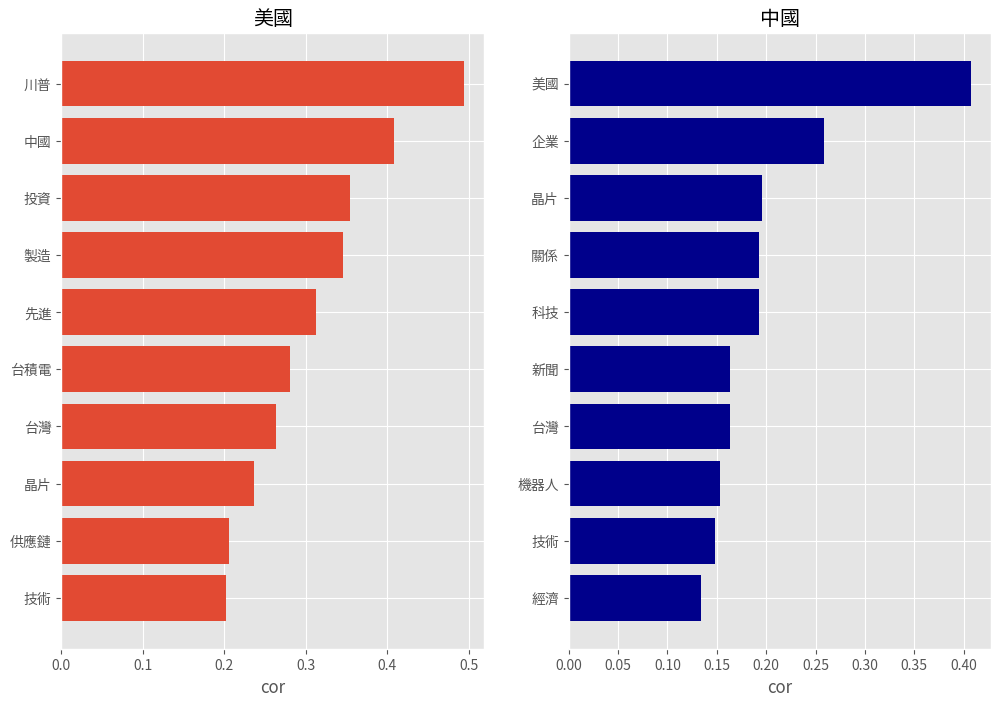

In [42]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('美國')
plt.xlabel('cor')
plt.barh(word1_sum['word2'],word1_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('中國')
plt.xlabel('cor')
plt.barh(word2_sum['word2'],word2_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

In [43]:
# 透過DTM找出詞頻前50高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(50).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [44]:
# 保留存在詞頻前50高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.4]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,主管,一些,0.565318
1,事情,一些,0.511440
2,學習,一些,0.456806
3,專案,一些,0.611981
4,履歷,一些,0.509431
...,...,...,...
217,管理,黃仁,0.522847
218,解決,黃仁,0.716346
219,語言,黃仁,0.699868
220,軟體,黃仁,0.481883


In [45]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

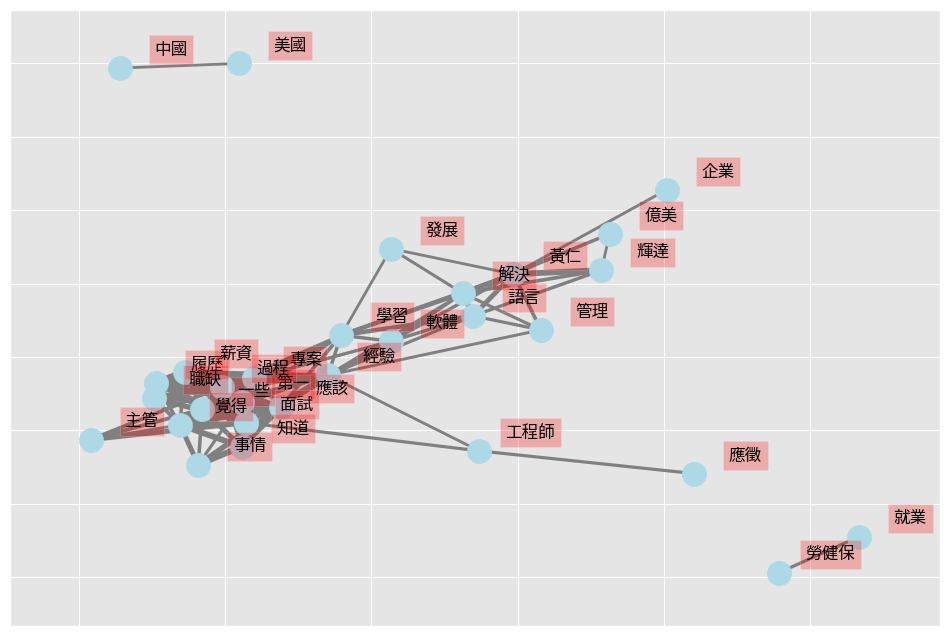

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()


- 中心詞如「面試」、「主管」、「履歷」、「薪資」等，形成一個以求職為核心的語意群落


- 右側詞彙如「輝達」、「企業」代表特定企業或科技產業語境


- 而如「中國」、「美國」、「勞健保」則處於相對獨立語境，說明主題上有所分離




整體來說，反映出 AI 討論早已不單純是科技話題，更牽涉到供應鏈布局、產業戰略與全球政經脈絡，也揭示出台灣在全球 AI 與晶片產業中，所扮演的關鍵角色。
